In [2]:
#last updated - 27-04-2024

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt



import os
from pymatgen.io.vasp.outputs import BSVasprun
from pymatgen.electronic_structure.plotter import BSDOSPlotter
from pymatgen.electronic_structure.bandstructure import get_reconstructed_band_structure, Spin

def generate_band_dat(vr_files):
    bandstructures = []
    for vr_file in vr_files:
        vr = BSVasprun(vr_file, parse_projected_eigen=False)
        bs = vr.get_band_structure(line_mode=True)
        bandstructures.append(bs)
    bs = get_reconstructed_band_structure(bandstructures)
    
    return save_band_dat(bs)

def save_band_dat(bs, prefix=None, directory=None):
    filename = f"{prefix}_band.dat" if prefix else "band.dat"
    directory = directory if directory else "."
    filename = os.path.join(directory, filename)

    if bs.is_metal():
        zero = bs.efermi
    else:
        zero = bs.get_vbm()["energy"]

    with open(filename, "w") as f:
        header = "#k-distance eigenvalue[eV]\n"
        f.write(header)

        for band in bs.bands[Spin.up]:
            for d, e in zip(bs.distance, band):
                f.write(f"{d:.8f} {e - zero:.8f}\n")
            f.write("\n")

        if bs.is_spin_polarized:
            for band in bs.bands[Spin.down]:
                for d, e in zip(bs.distance, band):
                    f.write(f"{d:.8f} {e - zero:.8f}\n")
                f.write("\n")

    return filename

# above code is do generate .dat file

def extract_lines(input_file, output_file, start_line=12, end_line=34):
#extract from input file start_line and end_line both included

  with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    for line_number, line in enumerate(infile, 1):
      if start_line <= line_number < end_line+1:
        outfile.write(line)


def startingPoint(bandNum,kp_num,sumo): 
      if(sumo==True):
          return 2+(bandNum-1)*kp_num+(bandNum-1)
      else:
         return 4+(bandNum-1)*kp_num+(bandNum-1)*2
      
def endingPoint(bandNum,kp_num,sumo):
      return startingPoint(bandNum,kp_num,sumo)+kp_num-1

def remove_space_and_get_words_and_numbers(text):
    # Remove all spaces from the text
    text = re.sub(r'\s+', '', text)
    
    # Split the text into words and numbers using regular expression
    # \w+ matches any word character (alphanumeric or underscore) one or more times
    # \d+ matches any digit character one or more times
    words_and_numbers = re.findall(r'\w+|\d+', text)
    
    return words_and_numbers

def postCalc( select_band ):
    select_band['Energy (au)'] = select_band['energy']/27.2112
    select_band['K-Points (1/au)'] = select_band['band_index']*0.592 

    #substract the initial Kpoint value
    initial_kpoint_value = select_band['K-Points (1/au)'].values[0]
    select_band['K-Points (1/au) Subs'] = select_band['K-Points (1/au)']-initial_kpoint_value
    
    #substract the initial energy value
    initial_kpoint_value = select_band['Energy (au)'].values[0]
    select_band['Energy (au) Subs'] = select_band['Energy (au)']-initial_kpoint_value
    return select_band

#function to select the data frame 
def band_selection(df_band , lim_kpoints , band_type='vb' , direc=True):  #direc = true means forward

    #find the max value in the valence band
    if(band_type=='vb'):
        selected_band=df_band['energy'].idxmax()
        # print("Corresponding VBM is \n", df_band.loc[ selected_band ])
    else:  #for CB
        selected_band=df_band['energy'].idxmin()
        # print("Corresponding CBM is \n", df_band.loc[ selected_band ])

    #select the prev and next values
    if direc == True:
        temp_df=pd.DataFrame(df_band.loc[ selected_band : selected_band+lim_kpoints-1 ])
        return postCalc( temp_df )
    else:
        temp_df= pd.DataFrame(df_band.loc[ selected_band - lim_kpoints + 1 : selected_band ])
        return postCalc( temp_df )

def in_excel( my_text , my_df , excel_path , ex_row , ex_col , lim_kpoints):
    with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a',if_sheet_exists="overlay") as writer:
        my_text=pd.DataFrame([my_text])
        my_df.to_excel( writer, index=False, sheet_name='Sheet1',startcol=ex_col, startrow=ex_row)
        my_text.to_excel( writer, index=False, sheet_name='Sheet1',startcol=ex_col-1, startrow=ex_row)
    #to update the row
    return ex_row+lim_kpoints+3

def kp_FromDat(parent_datPath,using_sum):
     
    using_sumo=1
    if using_sumo==1:
        start_dat=1 #index 1
    else: 
        start_dat=3 #index 3

    with open(parent_datPath, 'r') as file:
            line_count = 0
            for line in file:
                s1 = [float(s) for s in re.findall(r'-?\d+\.?\d*', line)]
                if( line_count > 3  ):
                    if len(s1)==0:
                        break
                # print(s1)
                line_count+=1
    return line_count-start_dat


#fitting

def mass_cal(final_df,image_name):
    """
    this funtion takes the data frame and return the effective mass

    polyfit finds the equation such that it minimises the squared error 
    """

    if(len(final_df)==1):
        print("Mass = ", None)
        return None,None

    x = np.array(final_df["K-Points (1/au) Subs"])     # array([-4, -3, -2, -1,  0,  1,  2,  3,  4])
    y = np.array(final_df["Energy (au) Subs"])         # array([-1,  1, -1,  1, -1,  1, -1,  1,  0])

    # print(x)
    # print(y)
    c = np.polyfit(x, y, 2)
    # Returns a vector of coefficients p that minimises the squared error.

    #array([-6.32440476e-03,  9.92063492e-05,  1.77430556e-01, -1.38888889e-03,
    #       -1.42100694e+00,  4.86111111e-03,  3.24990079e+00, -3.57142857e-03,
    #       -1.00000000e+00])
    
    # print(c)
    c = [ '%.4f' % elem for elem in c ]

    # print("df is \n")
    # print(final_df)
    # print("df is \n")

    print("2 degree polynomail fit =>  " , c[0],"x^2 + ",c[1],"x" )
    equation = str("2 degree polynomail fit =>  " + c[0]+"x^2 + "+c[1]+"x")
    
    # Uncomment this to visualize the polyfit
    
    p = np.poly1d( np.polyfit(x, y, 2) )
    t = np.linspace(x.min(), x.max(), 50)

    fig, ax = plt.subplots()
    # Plotting our polynomial function
    ax.plot(t, p(t))
    ax.plot(x, y )
    plt.xlabel("K-Points(1/au)")
    plt.ylabel("Energy(au)")
    plt.legend(["Polyfit", "Dataset"], loc="upper left")
    plt.savefig(image_name, bbox_inches='tight', dpi=300)
    #plt.show()

    a = float(c[0])

    if a==0:
        mass= None
    else:
        mass = 1/(2*a)

    # a = 1/2m
    # mass = 1/(2*a)
    print("Mass = ", mass)
    return mass,equation



In [4]:
def info_from_outcar(OUTCAR_path):
        ################################################
    #extracting data from OUTCAR

    #find the line that has data of NKPTS and NELECT
    with open(OUTCAR_path, 'r') as f:
        for line in f.readlines():
            if 'k-points           NKPTS =' in line:
                band_line=line
            if 'NELECT =' in line:
                nelec_line=line


    # print("band line",band_line)
    # print("nelec_line",nelec_line)


    #extract all the numbers from the string and convert them into a list
    s1 = [float(s) for s in re.findall(r'-?\d+\.?\d*', nelec_line)]
    # print(nelec_line)

    NELECT=s1[0]     #check the number of electrons to find the VBM number

    s2 = [float(s) for s in re.findall(r'-?\d+\.?\d*', band_line)]
    # print(band_line)

    NKPTS=s2[0]

    return NELECT , NKPTS 


######
# data extracted from OUTCAR 
###
     


In [7]:


################################################
#take input

#if using the dat file from sumo - use 1

print("-------------------------")
print("-- Effective Mass Calculator")
print("Make sure OUTCAR and band.dat or BAND.dat are present in the same directory")
print("-------------------------\n")

# directory_path=str(input("Enter you current Path:\n"))
directory_path="./"
OUTCAR_path=directory_path+'OUTCAR'



# generating .dat file
# vr_files = ["path/to/vasprun.xml"]
# generate_band_dat(vr_files)


# using_sumo = bool(input("Enter 1 if data extrated from SUMO , 0 if extracted from Vaspkit ?\n"))
using_sumo = True

# lim_kpoints=int(input("How many K-Points you want to consider ?\n"))
lim_kpoints=4
#lim_kpoints-=1

# excel_path=str(input("Excel file name? \n"))+'.xlsx'
excel_path="temp"+'.xlsx'
excel_path=directory_path+excel_path
################################################

if(using_sumo==1):
    parent_datPath=directory_path+"band.dat"
else:
    parent_datPath=directory_path+"BAND_vasp.dat"

'''
################################################
#extracting data from OUTCAR

#find the line that has data of NKPTS and NELECT
with open(OUTCAR_path, 'r') as f:
    for line in f.readlines():
        if 'k-points           NKPTS =' in line:
            band_line=line
        if 'NELECT =' in line:
            nelec_line=line


# print("band line",band_line)
# print("nelec_line",nelec_line)


#extract all the numbers from the string and convert them into a list
s1 = [float(s) for s in re.findall(r'-?\d+\.?\d*', nelec_line)]
# print(nelec_line)

NELECT=s1[0]     #check the number of electrons to find the VBM number

s2 = [float(s) for s in re.findall(r'-?\d+\.?\d*', band_line)]
# print(band_line)

NKPTS=s2[0]
'''
######
# data extracted from OUTCAR 
###

NELECT, NKPTS   = info_from_outcar("./OUTCAR")


-------------------------
-- Effective Mass Calculator
Make sure OUTCAR and band.dat or BAND.dat are present in the same directory
-------------------------



In [9]:
NKPTS

45.0

In [ ]:
#handling the dat file

In [18]:
data = np.loadtxt( 'band.dat' )

In [19]:
data.shape

(9540, 2)

In [47]:
NKPTS*(int(cb)-1)-1

7154.0

In [70]:
data = np.loadtxt( 'band.dat' )
np.array_equal(data[int(NKPTS*(int(vb)-1)):int(NKPTS*(int(vb+1)-1))],np.array(df_vbm))

True

In [71]:
np.array_equal(data[int(NKPTS*(int(cb)-1)):int(NKPTS*(int(cb+1)-1))],np.array(df_cbm))

True

In [31]:
start_line_vb

7270.0

In [23]:
end_line_vb/46

159.0

In [40]:
start_line_cb - start_line_vb

46.0

NKPTS from OUTCAR =  45.0
NKPTS from .dat file =  45
VB is  159.0
CB is  160.0
- - - - -
CB Back
     band_index  energy  Energy (au)  K-Points (1/au)  K-Points (1/au) Subs  \
16    0.562797  1.4268     0.052434         0.333176              0.000000   
17    0.781242  1.0001     0.036753         0.462495              0.129320   
18    0.999687  0.6213     0.022833         0.591815              0.258639   
19    1.218133  0.4745     0.017438         0.721135              0.387959   

    Energy (au) Subs  
16          0.000000  
17         -0.015681  
18         -0.029602  
19         -0.034997  
2 degree polynomail fit =>   0.1538 x^2 +  -0.1516 x
Mass =  3.2509752925877766
- - -
CB Next
     band_index  energy  Energy (au)  K-Points (1/au)  K-Points (1/au) Subs  \
19    1.218133  0.4745     0.017438         0.721135              0.000000   
20    1.218133  0.4745     0.017438         0.721135              0.000000   
21    1.249643  0.4862     0.017868         0.739789              0

'\n\nfile1 = open(directory_path+"eff_mass_log.txt", "w")\nL = ["Effective Mass Calculation \n", ]\nL.append("_________\n"+"CB_Back\n"+str(cb_back_eq)+"\n"+"Mass = "+str(cb_back_mass)+"\n_________\n")\nL.append("_________\n"+"CB_Next\n"+str(cb_next_eq)+"\n"+"Mass = "+str(cb_next_mass)+"\n_________\n")\nL.append("_________\n"+"VB_Back\n"+str(vb_back_eq)+"\n"+"Mass = "+str(vb_back_mass)+"\n_________\n")\nL.append("_________\n"+"VB_Next\n"+str(vb_next_eq)+"\n"+"Mass = "+str(vb_next_mass)+"\n_________\n")\n\n# \n is placed to indicate EOL (End of Line)\nfile1.writelines(L)\nfile1.close()  # to change file access modes.\n\n'

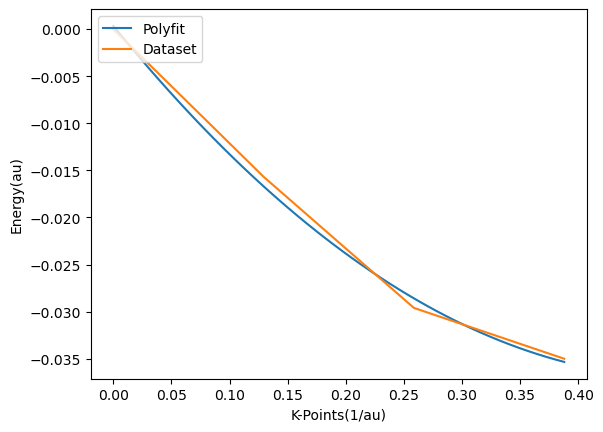

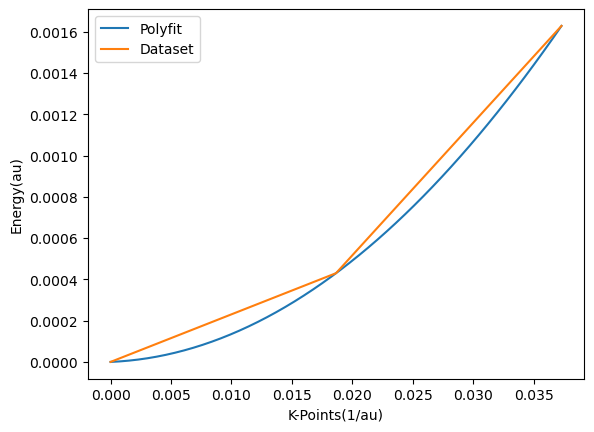

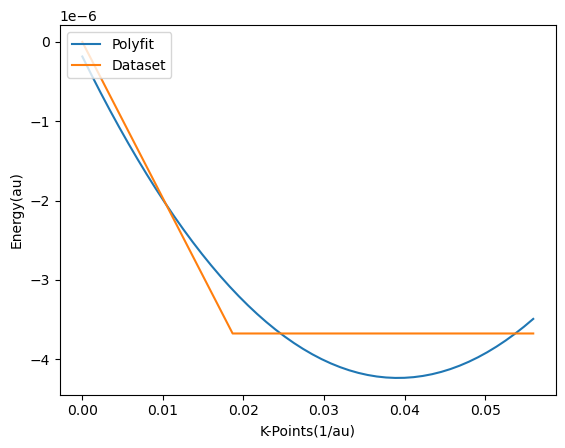

In [72]:

print("NKPTS from OUTCAR = ",NKPTS)



#generate band.dat file here


NKPTS_dat=kp_FromDat(parent_datPath,using_sumo)   #find the no of kpoints manually / from the band.dat file
print("NKPTS from .dat file = ",NKPTS_dat)

if(NKPTS_dat != NKPTS):
    print("I will be using No. K-Points = " , NKPTS_dat , " for this calculation")
    NKPTS=NKPTS_dat


#handling .dat file
vb=NELECT/2    # index of valance band = nelect/2
cb=vb+1

print('VB is ', vb)
print('CB is ', cb)
print('- - - - -')

data = np.loadtxt( 'band.dat' )
data_vbm = data[int(NKPTS*(int(vb)-1)):int(NKPTS*(int(vb+1)-1))]


# data_vbm = np.loadtxt(VBM_path,unpack=True)
x_vbm=data_vbm[:,0]
y_vbm=data_vbm[:,1]

#put all the values from VBM to a data frame
df_vbm = pd.DataFrame({'band_index':x_vbm, 'energy':y_vbm})



data_cbm = data[int(NKPTS*(int(cb)-1)):int(NKPTS*(int(cb+1)-1))]
# data_cbm=
# data_cbm = np.loadtxt(CBM_path,unpack=True)
x_cbm=data_cbm[:,0]
y_cbm=data_cbm[:,1]

#put all the values from VBM to a data frame
df_cbm = pd.DataFrame({'band_index':x_cbm, 'energy':y_cbm})



'''
# start_line_vb = startingPoint(vb,NKPTS,sumo=using_sumo)
# end_line_vb   = endingPoint(vb,NKPTS,sumo=using_sumo)

# print("starting line = ",start_line_vb, " ending line = ",end_line_vb)

#cb = vb+1

start_line_cb=startingPoint(cb,NKPTS,sumo=using_sumo)
end_line_cb=endingPoint(cb,NKPTS,sumo=using_sumo)

# print("starting line = ",start_line_cb, " ending line = ",end_line_cb)

# data of VB and CB is extracted in to the files named VBM and CBM

#change this if you want to change the name of the seprate VBM CBM files

VBM_path=directory_path+"VBM"
CBM_path=directory_path+"CBM"

extract_lines(parent_datPath,VBM_path,start_line_vb,end_line_vb)
extract_lines(parent_datPath,CBM_path,start_line_cb,end_line_cb)


#till now you have vbm.dat and cbm.dat file 
#till now this code need the OUTCAR file and band.dat file (both sumo or vaspkit will work)

data_vbm = np.loadtxt(VBM_path,unpack=True)
x_vbm=data_vbm[0]
y_vbm=data_vbm[1]

#put all the values from VBM to a data frame
df_vbm = pd.DataFrame({'band_index':x_vbm, 'energy':y_vbm})


data_cbm = np.loadtxt(CBM_path,unpack=True)
x_cbm=data_cbm[0]
y_cbm=data_cbm[1]

#put all the values from VBM to a data frame
df_cbm = pd.DataFrame({'band_index':x_cbm, 'energy':y_cbm})
'''



# after the data is loaded into df code will handle


#both the data is in a dataframe
################################################


vb_back=band_selection(df_vbm,lim_kpoints,band_type='vb',direc=False)
vb_next=band_selection(df_vbm,lim_kpoints,band_type='vb',direc=True)
cb_back=band_selection(df_cbm,lim_kpoints,band_type='cb',direc=False)
cb_next=band_selection(df_cbm,lim_kpoints,band_type='cb',direc=True)

# all set just put intoexcel
 

"""
for excel 
ex_col=1
ex_row=1

cb_back.to_excel(excel_path, index=False, engine='openpyxl', startcol=ex_col, startrow=ex_row)
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a',if_sheet_exists="overlay") as writer:
        my_text=pd.DataFrame(["CB Next"])
        my_text.to_excel( writer, index=False, sheet_name='Sheet1',startcol=ex_col-1, startrow=ex_row)


#to update the row
ex_row=in_excel('CB Back', cb_back , excel_path , ex_row , ex_col,lim_kpoints)
ex_row=in_excel('CB Next', cb_next , excel_path , ex_row , ex_col,lim_kpoints)
ex_row=in_excel('VB Back', vb_back , excel_path , ex_row , ex_col,lim_kpoints)
ex_row=in_excel('VB Next', vb_next , excel_path , ex_row , ex_col,lim_kpoints)
"""



# print('CB Back\n', cb_back )
# print('CB Next\n', cb_next )
# print('VB Back\n', vb_back )
# print('VB Next\n', vb_next )


#uncomment the below code to generate the log file

print('CB Back\n', cb_back )
cb_back_mass,cb_back_eq=mass_cal(cb_back,"CB_back")
print('- - -')
print('CB Next\n', cb_next )
cb_next_mass,cb_next_eq=mass_cal(cb_next,"CB_next")
print('- - -')
print('VB Back\n', vb_back )
vb_back_mass,vb_back_eq=mass_cal(vb_back,"VB_back")
print('- - -')
print('VB Next\n', vb_next )
vb_next_mass,vb_next_eq=mass_cal(vb_next,"VB_next")
print('- - -')

"""

file1 = open(directory_path+"eff_mass_log.txt", "w")
L = ["Effective Mass Calculation \n", ]
L.append("_________\n"+"CB_Back\n"+str(cb_back_eq)+"\n"+"Mass = "+str(cb_back_mass)+"\n_________\n")
L.append("_________\n"+"CB_Next\n"+str(cb_next_eq)+"\n"+"Mass = "+str(cb_next_mass)+"\n_________\n")
L.append("_________\n"+"VB_Back\n"+str(vb_back_eq)+"\n"+"Mass = "+str(vb_back_mass)+"\n_________\n")
L.append("_________\n"+"VB_Next\n"+str(vb_next_eq)+"\n"+"Mass = "+str(vb_next_mass)+"\n_________\n")

# \n is placed to indicate EOL (End of Line)
file1.writelines(L)
file1.close()  # to change file access modes.

"""